# Generating predictions for facial recognition using Deep Learning

The dataset used for this notebook is the [FER 2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset.
<br>
The dataset consists of 38x38 grayscale images from 7 different classes (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
<br><br>
I have used PyTorch as my choice of framework for generating and training the model.

In [1]:
import jovian
import os
import numpy as np
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import math
from PIL import Image

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

%matplotlib inline

### Loading the dataset

In [2]:
data_dir = "fer_2013/"

Listing our target classes

In [3]:
targets = os.listdir(data_dir + 'train')
targets

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Loading the data into tensors, applying data augmentation (random rotation by a factor of 30deg) and splitting the training data into training and validation sets.

In [34]:
validation_ratio = 0.1

train_transforms = tt.Compose([
    tt.Grayscale(1),
    tt.RandomRotation(30, tt.InterpolationMode.BICUBIC),
    tt.ToTensor(),
])

img_transforms = tt.Compose([
    tt.Grayscale(1),
    tt.ToTensor(),
])

train_data = ImageFolder(data_dir + 'train', train_transforms)
validation_len = math.floor(len(train_data) * validation_ratio)
validation_data, train_data = random_split(train_data, [validation_len, len(train_data) - validation_len], 
                                           generator=torch.Generator().manual_seed(7))

test_data = ImageFolder(data_dir + 'test', img_transforms)

### Counting the number of images in each category and creating a barplot to visualise the numbers

In [5]:
count = []
for folder in targets:
    num_images = len(os.listdir(data_dir + '/train/' + folder))
    count.append(num_images)
    print(f'There are {num_images} images in the {folder} category.')

There are 3995 images in the angry category.
There are 436 images in the disgust category.
There are 4097 images in the fear category.
There are 7215 images in the happy category.
There are 4965 images in the neutral category.
There are 4830 images in the sad category.
There are 3171 images in the surprise category.


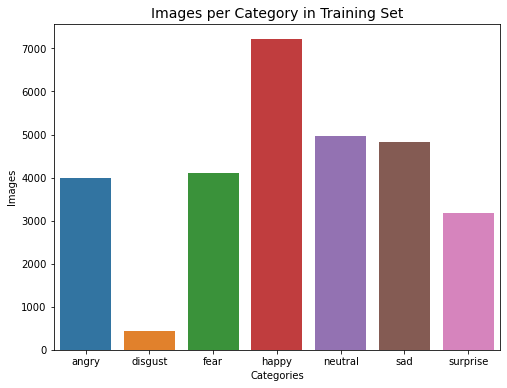

In [6]:
plt.figure(figsize=(8, 6))
sns.barplot(x=targets, y=count)
plt.title('Images per Category in Training Set', size=14)
plt.ylabel('Images')
plt.xlabel('Categories')
plt.show;

From the above the dataset we can see that the disgust class has very low number of images so predictions involving disgust category won't be very accurate in our model.

In [8]:
len(train_data)

25839

Displaying a sample image in the training dataset:

image.shape: torch.Size([1, 48, 48])
Label: neutral


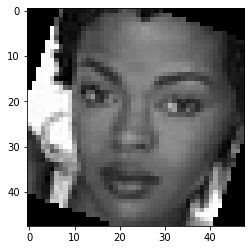

In [9]:
image, label = train_data[25000]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', targets[label])

Loading the datasets into PyTorch dataloaders to train the model using batches:

In [10]:
train_dl = DataLoader(
    train_data,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

valid_dl = DataLoader(
    validation_data,
    batch_size=128,
    num_workers=4,
    pin_memory=True,
)

test_dl = DataLoader(
    test_data,
    batch_size=128,
    num_workers=4,
    pin_memory=True,
)


Visualising a batch from training dataloader with 128 images:

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

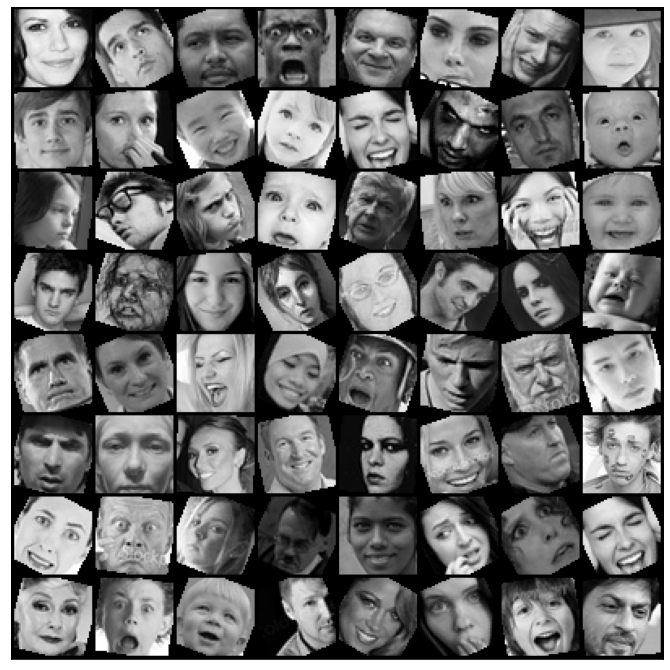

In [12]:
show_batch(train_dl)

### Helper functions for using the GPU:
Class DeviceDataLoader loads a dataloader into the chosen device's memory

In [13]:
#checking for cuda drivers if available
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
print(device)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

cuda


### Defining our model

ImageClassificationBase class helps us generalise our code for most Image Classification models as it contains steps generally used during image classification.

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

Defining our model. Using the architecture of the ResNet9 model and training it from scratch:

In [16]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [17]:
model = to_device(ResNet9(1, 7), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### Training our model

Defining functions to train the model:

In [18]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

If model has already been trained and we want to load pretrained weights:

In [20]:
# To load pretrained weights
model.load_state_dict(torch.load("resnet9_fer2013.pth"))

<All keys matched successfully>

Getting a baseline accuracy for our model.
As expected it is about 14%, which is the accuracy we'd expect if one were randomly guessing the classes for the images (1 in 7 chance of getting the class correct).

In [44]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.946286916732788, 'val_acc': 0.146261066198349}]

Training our model. We are using Adam optimiser and One Cycle Learning rate policy as defined in the above fit_one_cycle function.

In [45]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [46]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00104, train_loss: 1.7950, val_loss: 1.6109, val_acc: 0.3412
Epoch [1], last_lr: 0.00279, train_loss: 1.4777, val_loss: 1.3216, val_acc: 0.5025
Epoch [2], last_lr: 0.00519, train_loss: 1.3387, val_loss: 1.3074, val_acc: 0.5156
Epoch [3], last_lr: 0.00760, train_loss: 1.2689, val_loss: 1.3108, val_acc: 0.4942
Epoch [4], last_lr: 0.00936, train_loss: 1.2303, val_loss: 1.3972, val_acc: 0.4550
Epoch [5], last_lr: 0.01000, train_loss: 1.2085, val_loss: 1.2435, val_acc: 0.5253
Epoch [6], last_lr: 0.00987, train_loss: 1.1835, val_loss: 1.1941, val_acc: 0.5506
Epoch [7], last_lr: 0.00950, train_loss: 1.1596, val_loss: 1.1971, val_acc: 0.5533
Epoch [8], last_lr: 0.00891, train_loss: 1.1447, val_loss: 1.1976, val_acc: 0.5480
Epoch [9], last_lr: 0.00812, train_loss: 1.1336, val_loss: 1.1376, val_acc: 0.5431
Epoch [10], last_lr: 0.00717, train_loss: 1.1124, val_loss: 1.2748, val_acc: 0.5224
Epoch [11], last_lr: 0.00611, train_loss: 1.0840, val_loss: 1.1375, val_acc: 0.5669
Ep

Saving our trained weights

In [47]:
torch.save(model.state_dict(), 'resnet9_fer2013.pth')

In [48]:
# Saving the training time for logging metrics
train_time = '17:28'

Function for plotting model validation accuracies against number of epochs it was trained for

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

Logging hyperparameters and metrics

In [50]:
jovian.reset()
jovian.log_hyperparams(arch='test 5: resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay,
                       grad_clip=grad_clip, 
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [51]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


### Testing our model

In [21]:
evaluate(model, test_dl)

{'val_loss': 0.9209866523742676, 'val_acc': 0.6727247834205627}

As we can see above, the model has a testing set accuracy of 67.27%

Defining a function to generate predictions on individual pictures provided by user

In [54]:
def predict_img(img):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, pred = torch.max(yb, dim=1)
    print(f'Predicted: {targets[pred]}')
    plt.imshow(img.permute(1, 2, 0), cmap='gray')

Converting test images to Grayscale, transforming them to tensors and resizing them to 48x48 (as required by our model)

In [61]:
test_img1 = Image.open('ik.jpeg')
test_img2 = Image.open('ik2.jpeg')
transform = tt.transforms.Compose([
    tt.Grayscale(1),
    tt.ToTensor(),
    tt.Resize((48,48))
])
test_img1 = transform(test_img1)
test_img2 = transform(test_img2)
#plt.imshow(test_img.permute(1,2,0), cmap='gray')

Predicted: happy


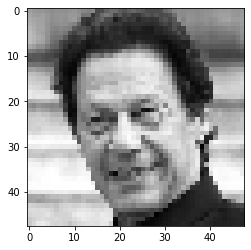

In [62]:
predict_img(test_img1)

Predicted: neutral


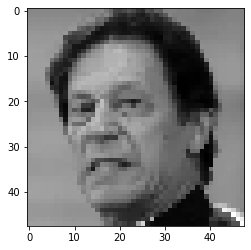

In [63]:
predict_img(test_img2)